xvector_inspection 
------------------------

왜 xvector는 PDLA에서 엄청나게 좋은 성능을 내는가?

다른 논문에서는 xvector+LDA/PLDA가 엄청나게 좋은 성능을 보이지 않는데.. 혹시 augmentation 효과가 큰건가?

일단 dvector와 무엇이 다른지 emprical하게 알아보고자 한다.

- input_frame에 따른 성능변화의 차이?


### Environment

In [51]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import pandas as pd
import pickle
import numpy as np
import sys
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
sys.path.append('/host/projects/sv_experiments/')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
si_keys = pickle.load(open("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/train_feat/key.pkl", "rb"))
si_embeds = np.load("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/train_feat/feat.npy")

sv_keys = pickle.load(open("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/test_feat/key.pkl", "rb"))
sv_embeds = np.load("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/test_feat/feat.npy")

In [6]:
def key2df(keys):
    key_df = pd.DataFrame(keys, columns=['key'])
    key_df['spk'] = key_df.key.apply(lambda x: x.split("-")[0])
    key_df['label'] = key_df.groupby('spk').ngroup()
    key_df['origin'] = key_df.spk.apply(lambda x: 'voxc2' if x.startswith('id') else 'voxc1')
    
    return key_df

In [7]:
si_key_df = key2df(si_keys)
sv_key_df = key2df(sv_keys)

### T-SNE

In [100]:
si_all_spks = si_key_df.spk.unique().tolist()
sv_all_spks = sv_key_df.spk.unique().tolist()

In [110]:
tsne_size =  40
tsne_spks = np.random.choice(sv_all_spks, size=tsne_size, replace=False)
spk2label = {k:i for i, k in enumerate(tsne_spks)}

In [107]:
tsne_df = sv_key_df[sv_key_df.spk.isin(tsne_spks)]

In [108]:
tsne_embeds = si_embeds[tsne_df.index]

In [109]:
# %%time
import numpy as np
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
X = tsne_embeds
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(4874, 2)

In [116]:
import matplotlib.cm as cm
colors = cm.rainbow_r(np.linspace(0, 1, tsne_size))
c_label = tsne_df.spk.apply(lambda x: tsne_spks.tolist().index(x))

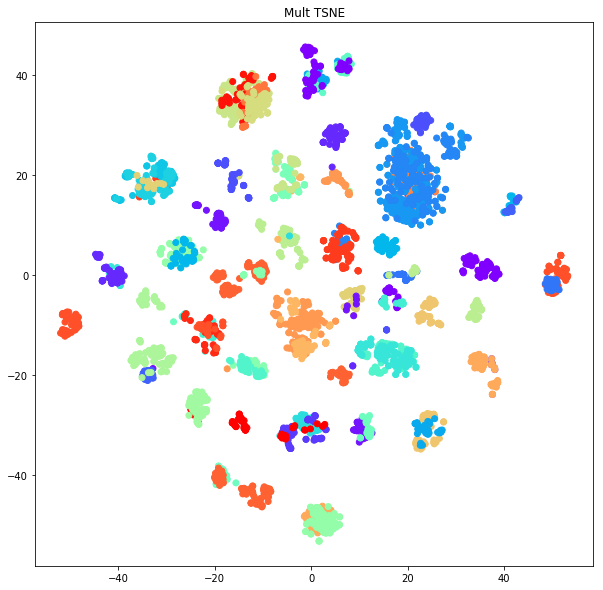

In [117]:
plt.figure(figsize=(10,10))
plt.title("Mult TSNE")
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors[c_label])

In [50]:
np.save("xvector_tsne_points.npy", X_embedded)

si_100_df.to_pickle("xvector_tsne_df.pkl")